In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset,DataLoader
import math
import collections
import re

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5,2.5)):
    num_rows, num_columns, _, _ = matrices.shape
    fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize,sharex=True,sharey=True, squeeze=False)
    for i,(row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax,matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().cpu().numpy())
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

In [7]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=float('-inf'))
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [8]:
class DotProductAttention(nn.Module):
    """scaled dot product attention"""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens = None):
        """
        queries: tensor shape B, num_querie, d
        keys: tensor shape B, num_keys, d
        values: tensor shape B, num_keys, value dim
        valid_lens: tensor shape B,num_queries
        """
        d = queries.shape[-1]
#         print(d)
        scores = torch.bmm(queries, keys.transpose(-1,-2))/math.sqrt(d)
#         print(scores)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)
    

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(hidden_size, bias=bias)
        self.W_k = nn.LazyLinear(hidden_size, bias=bias)
        self.W_v = nn.LazyLinear(hidden_size, bias=bias)
        self.W_o = nn.LazyLinear(hidden_size, bias=bias)
        
    def forward(self, queries, keys, values, valid_lens):
#         queries: tensor shape B, num_querie, d
#         keys: tensor shape B, num_keys, d
#         values: tensor shape B, num_keys, value dim
#         valid_lens: tensor shape B,num_queries
#         test_1 = self.W_q(queries)
#         print(test_1.shape)
#         print(valid_lens)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, self.num_heads, dim=0)
        output = self.attention(queries, keys, values, valid_lens)
        
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)
    def transpose_qkv(self,X):
#         X: shape B, no. of queries or keys, hidden_size
        B, T, C =  X.shape
        head_size = C//self.num_heads
        X = X.reshape(B, T, self.num_heads, -1)#B,T,num_heads,C/num_heads
#         print(X.shape)
        X = X.permute(0,2,1,3)#B,num_head,T,head_size(num_embd//head_size)
#         print(X.shape)
        X = X.reshape(-1,T,head_size)
#         print(X.shape)
        return X#B*num_heads,T,head_size
    def transpose_output(self,X):
        #reverse transpose qkv
        X = X.reshape(-1, self.num_heads, X.shape[1],X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0],X.shape[1],-1)
    

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hidden, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hidden))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
        -1, 1)/ torch.pow(10000,torch.arange(0,num_hidden,2,dtype=torch.float32)\
                          /num_hidden)
        self.P[:,:,0::2] = torch.sin(X)
        self.P[:,:,1::2] = torch.cos(X)
        
    def forward(self, X):
        X = X + self.P[ :, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [11]:
class PositionWiseFFN(nn.Module):
    """poinstwise(positionwise) feed foward layer"""
    def __init__(self, ffn_num_hidden, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hidden)#projecing to intermediate
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)#projecting back
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [12]:
class AddNorm(nn.Module):
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)#d~norm_shape
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [13]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, hidden_size, ffn_num_hidden, num_heads,
                 dropout, bias=False):
        super().__init__()
        
        self.attention = MultiHeadAttention(hidden_size, num_heads, dropout, bias)
        self.addnorm1 = AddNorm(hidden_size, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hidden, hidden_size)
        self.addnorm2 = AddNorm(hidden_size,dropout)
    
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [14]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, ffn_num_hidden,
                num_heads, num_blks, dropout, max_len=1000, bias=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoding = PositionalEncoding(hidden_size, dropout)        
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block" + str(i), TransformerEncoderBlock(
            hidden_size, ffn_num_hidden, num_heads, dropout, bias))
    
    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.hidden_size))
        self.attention_weights = []
        for i,blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights.append(blk.attention.attention.attention_weights)
        return X
    #no encoder_valid_lens output for machine translation?

In [29]:
class TransformerDecoderBlock(nn.Module):
    # the i-th block in Transformer decoder
    def __init__(self, hidden_size, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i =i
        self.attention1 = MultiHeadAttention(hidden_size, num_heads, dropout)
        self.addnorm1 = AddNorm(hidden_size, dropout)
        self.attention2 = MultiHeadAttention(hidden_size, num_heads, dropout)
        self.addnorm2 = AddNorm(hidden_size, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, hidden_size)
        self.addnorm3 = AddNorm(hidden_size, dropout)
        
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0],state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i],X),dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            #dec_valid_lens;batch_size,num_steps
            dec_valid_lens = torch.arange(1,num_steps + 1,device=X.device).repeat(batch_size, 1)
#             print(dec_valid_lens.shape)
        else:
            dec_valid_lens = None
        #attention:q,k,v
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
#         print("X_shape",X.shape,"key_values", key_values.shape)
#         print("dec_attention_shape",self.attention1.attention.attention_weights.shape)
        Y = self.addnorm1(X, X2)
#         print("Y and enc_out",Y.shape, enc_out.shape)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
#         print("enc_attention_shape",self.attention2.attention.attention_weights.shape)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state


In [30]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, ffn_num_hiddens, num_heads, num_blks, dropout,max_len=1000):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoding = PositionalEncoding(hidden_size, dropout)
        self.blks = nn.Sequential()
        for i in range(self.num_blks):
            self.blks.add_module("block" + str(i),TransformerDecoderBlock(hidden_size, 
                                                    ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None]*self.num_blks]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.hidden_size))
        self._attention_weights = [[None]*len(self.blks) for _ in range(2)]
        for i,blk in enumerate(self.blks):
            X, state = blk(X, state)
            #Decoder self attention weights
            self._attention_weights[0][i]=\
            blk.attention1.attention.attention_weights
            # encoder- decoder attention weights
            self._attention_weights[1][i]=\
            blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weigths

In [31]:
class EncoderDecoder(nn.Module):  
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, enc_valid_lens):
        enc_all_outputs = self.encoder(enc_X, enc_valid_lens)
        dec_state = self.decoder.init_state(enc_all_outputs,enc_valid_lens)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]
    
    def predict(self, batch,eos_token,max_len=10):
        src,tgt,src_valid_len,_ = batch
        enc_all_outputs = self.encoder(src,src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs,src_valid_len)
        outputs = [tgt[:,(0)].unsqueeze(1)]
        while(True):
            Y, dec_state = self.decoder(outputs[-1],dec_state)
            outputs.append(Y.argmax(2))
            if len(outputs) > max_len:break
        return outputs

In [32]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        #count token frequencies
        if tokens and isinstance(tokens[0],list):
            tokens = [token for line in tokens for token in line]
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
        
        #list of unique tokens
        self.itos = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.stoi = {token: idx for idx,token in enumerate(self.itos) }
        
    def __len__(self):
        #length of vocabulary
        return len(self.itos)
    
    def __getitem__(self, tokens):
        #make tokens into indices
        if not isinstance(tokens,(list,tuple)):
            return self.stoi.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self,indices):
        #make indixes into tokens
        if hasattr(indices,'__len__') and len(indices)>1:
            return [self.itos[int(index)] for index in indices]
        return slef.itos[indices]
    
    @property
    def unk(self):
        return self.stoi['<unk>']
class MTFraEng(Dataset):
    def __init__(self, num_steps=9, num_train=512*4, num_val=128*4, train=True):
        super().__init__()
        
        self.num_steps = num_steps
        self.num_train = num_train
        self.num_val = num_val
        self.train = train
        #array and vocabs:
        self.arrays, self.src_vocab,self.target_vocab = self._build_arrays(self._load())
        
    def _load(self,path='/kaggle/input/english-to-french/fra.txt'):
        with open(path,"r",encoding='utf-8') as f:
            return f.read()
        
    def _preprocess(self, txt):
        txt = txt.replace('\u202f', ' ').replace('\xa0', ' ')
        out = ''
        for i,char in enumerate(txt):
            if char in ',.!?' and txt[i-1] != ' ':
                out += ' ' + char
            else:
                out += char
        return out.lower()
    
    def _tokenize(self, txt, max_examples=None):
        src,tgt = [],[]
        for i,row in enumerate(txt.split('\n')):
            if max_examples and i > max_examples:break
            split_ = row.split('\t')
            if len(split_) > 1:
                src.append(split_[0].split(' ') + ['<eos>'])
                tgt.append(split_[1].split(' ') + ['<eos>'])    
        return src,tgt
    
    def _build_array(self, sentences, vocab=None, is_tgt=False):
        pad_or_trim = lambda seq,max_len:(
        seq[:max_len] if len(seq) >= max_len else seq + ['<pad>']*(max_len-len(seq)))
        sentences = [pad_or_trim(s,self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.float32).sum(1)
        return array, vocab, valid_len
    
    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        src,tgt = self._tokenize(self._preprocess(raw_text),self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = self._build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = self._build_array(tgt, tgt_vocab, is_tgt=True)
        if self.train:
            return ((src_array[:self.num_train], tgt_array[:,:-1][:self.num_train], src_valid_len[:self.num_train], tgt_array[:,1:][:self.num_train]),
                   src_vocab,tgt_vocab)
        else:
            return ((src_array[self.num_train:self.num_train + self.num_val], tgt_array[:,:-1][self.num_train:self.num_train + self.num_val], \
                     src_valid_len[self.num_train:self.num_train + self.num_val], tgt_array[:,1:][self.num_train:self.num_train + self.num_val]),
                   src_vocab,tgt_vocab)
        
    def build(self, src_sentences, tgt_sentences):
        raw_text = '\n'.join([src + '\t' + tgt for src,tgt in zip(src_sentences,tgt_sentences)])
        arrays,_,_ = self._build_arrays(raw_text, self.src_vocab, self.target_vocab)
        return arrays
    def __getitem__(self,index):
        return self.arrays[0][index],self.arrays[1][index],self.arrays[2][index],self.arrays[3][index]
    
    def __len__(self):
        return self.arrays[0].shape[0]

In [33]:
data = MTFraEng(train=True)
train_dataloader = DataLoader(data, batch_size=128)

In [34]:
hidden_size, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 256, 8

In [35]:
encoder = TransformerEncoder(
    len(data.src_vocab), hidden_size, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.target_vocab), hidden_size, ffn_num_hiddens, num_heads,
    num_blks, dropout)

In [36]:
model = EncoderDecoder(encoder, decoder).to(device)

In [37]:
def masked_loss(logits, labels,tgt_pad):
    probs = F.softmax(logits, dim=-1)
    loss = - torch.log(probs[range(probs.shape[0]),labels])
    mask = (labels != tgt_pad).type(torch.float32).to(logits.device)
    
    return torch.mean(loss*mask)

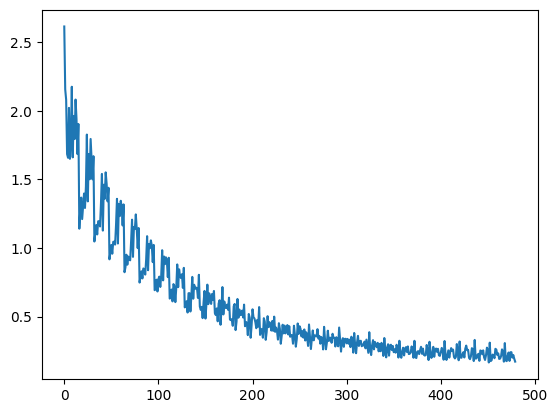

In [38]:
lr = 1e-3
num_epochs = 30
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
tgt_pad = data.target_vocab['<pad>']
loss_ = []
model.train()
for epoch in range(num_epochs):
    
    for i,sample in enumerate(train_dataloader):
        out = model(sample[0].to(device),sample[1].to(device),sample[2].to(device))
        B,T,C = out.shape
        out = out.reshape(B*T,-1).to(device)
        label = sample[3]
        label = label.reshape(B*T,)
        optimizer.zero_grad()
        loss = masked_loss(out,label,tgt_pad)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1)
        optimizer.step()
        loss_.append(loss.detach().cpu())
plt.plot(loss_)

In [39]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
sample = data.build(engs,fras)
sample = tuple([sample_.to(device) for sample_ in sample])

In [40]:
model.eval()
pred = model.predict(sample,data.target_vocab['<eos>'])

In [41]:
str_ = ''
for i in range(4):
    for token in pred:
        str_ += data.target_vocab.itos[token[i].squeeze().item()] + ' '
    str_+='\n'

In [42]:
print(str_)

<bos> allez ! <eos> ! <eos> ! <eos> ! <eos> ! 
<bos> j'ai perdu . <eos> perdu . <eos> perdu . <eos> 
<bos> il est calme . <eos> <unk> . <eos> . <eos> 
<bos> je suis chez moi . <eos> à la maison . 

